In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

### Leggo i dati

In [3]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

### Costruisco $B_{test}$
Le matrici hanno $1$ in presenza di link e $-1$ in assenza.<br>
Per costruire $B_{train}$ incorporo inoltre degli elementi nulli che rappresentano i link incogniti

In [4]:
proporzione_train_test = 0.99

diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B_test  = np.ones((len(diseases), len(chemicals))) * -1.

print("Costruisco B_test")

for i,t in enumerate(data):
    if i % 100000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B_test[idx_dis, idx_chem] = 1.

Costruisco B_test
0.00 %
21.43 %
42.86 %
64.29 %
85.72 %


### Produzione del training set $\Omega$

In [6]:
def build_training_set(B_test, proporzione_train_test):
    B_train     = B_test.copy()
    censor_mask = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
    B_train *= censor_mask
    return B_train

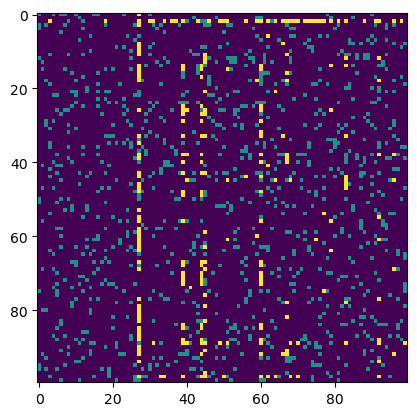

In [8]:
B_train = build_training_set(B_test,0.9)
plt.imshow(B_train[:100,:100])

# Plain experiment

Faccio girare un esperimento con $m,\gamma,\epsilon_0$ fissati
 

In [9]:
def predict(V,W, temp):
    VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
    return jnp.tanh( temp * VWT )

def loss(V,W,B, temp = 1.):
    BALANCE = (B == 1.) * ( (B == -1).sum() / (jnp.abs(B).sum())) + (B == -1.) * ( (B == +1).sum() / (jnp.abs(B).sum())) 
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 * BALANCE )  / jnp.abs(BALANCE).sum() 

loss = jax.jit(loss)
grad = jax.jit(jax.grad(loss, argnums = (0,1)))
m = 3
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
print(loss(V,W,B_train))

1.5093353


### Trainer

In [67]:
def train(B_train,B_test,m,gamma,epsilon_0,maxiter = 500, tol = 1e-5, mute = False, set_seed = True):
    if set_seed == True:
        np.random.seed(123)
    B_train_jnp = jnp.array(B_train)
    V = jnp.array(np.random.randn(len(diseases), m))
    W = jnp.array(np.random.randn(len(chemicals),m))
    alfa = 10.
    T = epsilon_0
    G = grad(V,W,B_train_jnp, temp = T)
    for i in range(maxiter):   
        T = (1. + gamma) * T  
        G = grad(V,W,B_train_jnp, temp = T)
        
        # condizione di uscita
        
        if( (jnp.linalg.norm(G[0]) + jnp.linalg.norm(G[1])) < tol ):
            break
        
        
        newV = V - alfa * G[0]
        newW = W - alfa * G[1]
        if(loss(newV,newW,B_train_jnp) < loss(V,W,B_train_jnp)):
            alfa *= 1.1
            V = newV
            W = newW
        else:
            alfa *= 0.5
        if i % 100 == 0:
            if not mute:
                print(loss(V,W,B_train_jnp), loss(V,W,B_test * (B_train_jnp == 0) ), T , "grad_V(L) = %f" %  jnp.linalg.norm(G[0]) , "grad_W(L) = %f" % jnp.linalg.norm(G[1]))
    
    return V,W

In [37]:
def confusion_matrix(V,W,B_test):
    B_hat = predict(V,W,1.)
    th = - 0.
    TP = (((B_test * B_hat) >= th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum() 
    FN = (((B_test * B_hat) <  th) * (B_test ==   1))[B_train == 0.].sum() / (B_test == 1.)[B_train == 0.].sum()
    TN = (((B_test * B_hat) >= th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum() 
    FP = (((B_test * B_hat) <  th) * (B_test ==  -1))[B_train == 0.].sum() / (B_test ==-1.)[B_train == 0.].sum()
    C = np.array( [  
                        [TP, FN], 
                        [FP, TN]
    ] )
    return C

In [30]:
B_train = build_training_set(B_test,0.9)
V,W = train(B_train,B_test, 10, 1e-3, 1e-1, mute = True)
confusion_matrix(V,W,B_test)

array([[0.9193127 , 0.08068732],
       [0.06557363, 0.9344264 ]], dtype=float32)

# $m$ selection

In [52]:
scores = list()
training_sets = 30
B_trains = [
        build_training_set(B_test,0.9)
    for i in range(training_sets)
]

for m in range(3,70):
    confusion_matrices = list()
    for i in range(training_sets):
        print("\t%d"% i)
        B_train = B_trains[i]
        V,W = train(B_train,B_test, m, 1e-3, 1e-1, mute = True)
        confusion_matrices.append( confusion_matrix(V,W,B_test) )
    confusion_matrices = np.array(confusion_matrices)
    curr_confusion_matrix   = confusion_matrices.mean(axis = 0)
    scores.append( np.array([curr_confusion_matrix[0,0], curr_confusion_matrix[1,1]]) )
    print(m, scores[-1])

	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
3 [0.92656094 0.9122622 ]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
4 [0.9289999 0.9173276]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
5 [0.9287099  0.92111593]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
6 [0.9280535 0.923708 ]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
7 [0.92723376 0.92668587]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
8 [0.92497665 0.9295622 ]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
9 [0.922652   0.93202823]
	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	1

KeyboardInterrupt: 

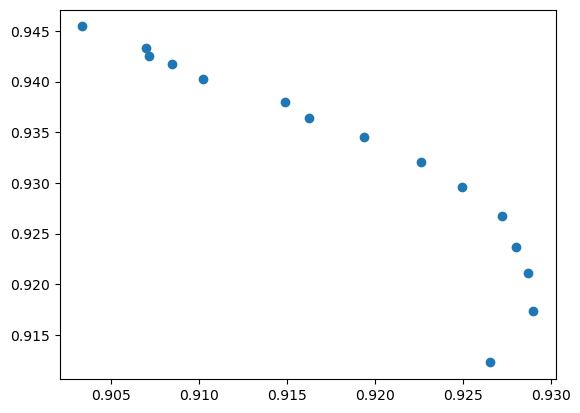

In [53]:
plt.scatter(np.array(scores)[:,0],np.array(scores)[:,1])

# Scatter of representations of confusion matrices

	0
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
	30
	31
	32
	33
	34
	35
	36
	37
	38
	39
	40
	41
	42
	43
	44
	45
	46
	47
	48
	49
	50
	51
	52
	53
	54
	55
	56
	57
	58
	59
	60
	61
	62
	63
	64
	65
	66
	67
	68
	69
	70
	71
	72
	73
	74
	75
	76
	77
	78
	79
	80
	81
	82
	83
	84
	85
	86
	87
	88
	89
	90
	91
	92
	93
	94
	95
	96
	97
	98
	99
	100
	101
	102
	103
	104
	105
	106
	107
	108
	109
	110
	111
	112
	113
	114
	115
	116
	117
	118
	119
	120
	121
	122
	123
	124
	125
	126
	127
	128
	129
	130
	131
	132
	133
	134
	135
	136
	137
	138
	139
	140
	141
	142
	143
	144
	145
	146
	147
	148
	149
	150
	151
	152
	153
	154
	155
	156
	157
	158
	159
	160
	161
	162
	163
	164
	165
	166
	167
	168
	169
	170
	171
	172
	173
	174
	175
	176
	177
	178
	179
	180
	181
	182
	183
	184
	185
	186
	187
	188
	189
	190
	191
	192
	193
	194
	195
	196
	197
	198
	199
	200
	201
	202
	203
	204
	205
	206
	207
	208
	209
	210
	211
	212
	213
	214
	215
	216
	217
	218
	219
	220
	221


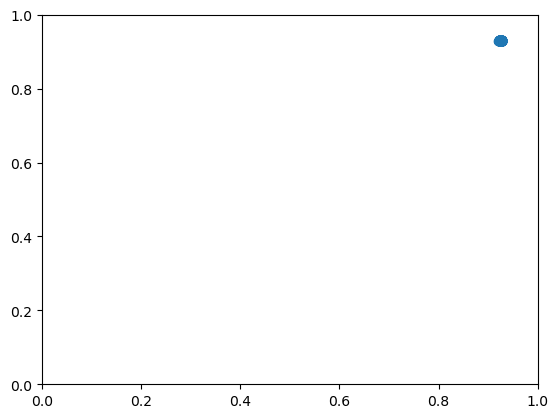

In [74]:
training_sets = 500
confusion_matrices = list()
np.random.seed(123)
m = 8
for i in range(training_sets):
    print("\t%d"% i)
    B_train = build_training_set(B_test,0.9)
    V,W = train(B_train,B_test, m, 1e-3, 1e-1, mute = True, set_seed = False)
    confusion_matrices.append( confusion_matrix(V,W,B_test))

confusion_matrices_scores = np.array([ 
        np.array([ c[0,0], c[1,1] ])
    for c in confusion_matrices
])

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(confusion_matrices_scores[:,0], confusion_matrices_scores[:,1])

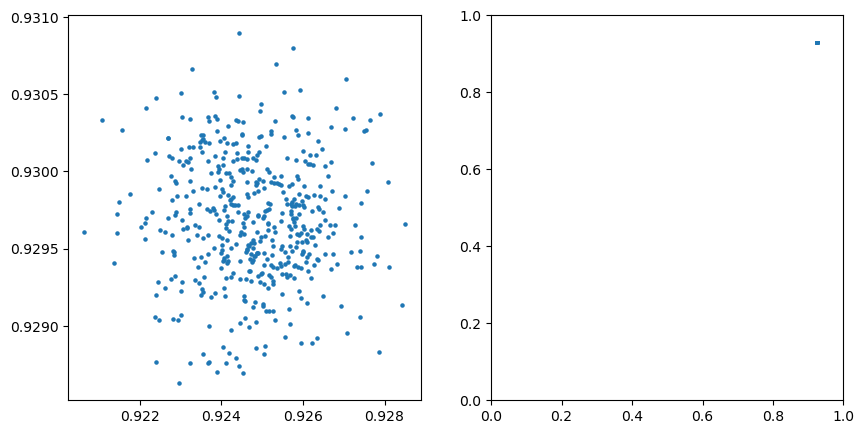

In [91]:
axs = plt.figure(figsize=(10,5)).subplots(1,2).flatten()
axs[0].scatter(confusion_matrices_scores[:,0], confusion_matrices_scores[:,1], s = 5)
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].scatter(confusion_matrices_scores[:,0], confusion_matrices_scores[:,1], s = .5)

<AxesSubplot:>

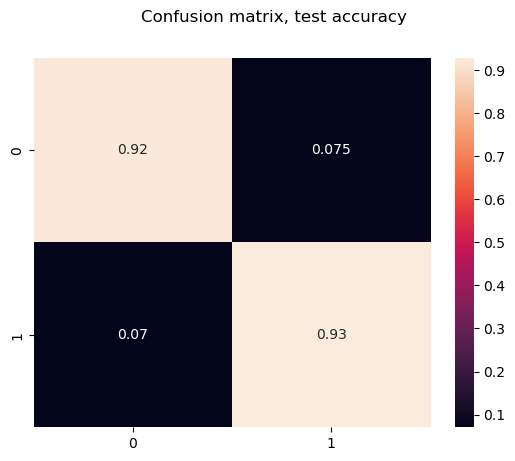

In [101]:
a,b = confusion_matrices_scores.mean(axis = 0)
import seaborn as sns
plt.suptitle("Confusion matrix, test accuracy")
sns.heatmap(
    np.array([
        [a,1-a],
        [1-b,b]
    ])
    , annot = True
)

# Embedding analysis of diseases

In [103]:
import urllib.request
def get_mesh_title(mesh_id):
    fp = urllib.request.urlopen("https://meshb.nlm.nih.gov/record/ui?ui=%s" % mesh_id)
    mybytes = fp.read()

    mystr = mybytes.decode("utf8")
    fp.close()
    tokens = mystr.split("\n")
    return (tokens[105][4:].split("<small>")[0] )

In [130]:
B_train = build_training_set(B_test,0.95)
V,W = train(B_train,B_test, 30, 1e-3, 1e-1, mute = True, set_seed = True)
confusion_matrix(V,W,B_test)

array([[0.8854247 , 0.11457535],
       [0.04357474, 0.9564253 ]], dtype=float32)

Diabetes Mellitus 
Hyperglycemia 
Obesity 
Barrett Esophagus 
Hyperplasia 
Asphyxia Neonatorum 
Necrosis 
Proteinuria 
Prostatic Neoplasms 
Carcinoma, Pancreatic Ductal 
Hyperthyroidism 
Esophageal Neoplasms 
Diabetes Mellitus, Experimental 
Arteriosclerosis 
Coronary Artery Disease 
Diabetic Retinopathy 
Hyperlipidemias 
Fatty Liver 
Liver Cirrhosis, Experimental 
Acatalasia 


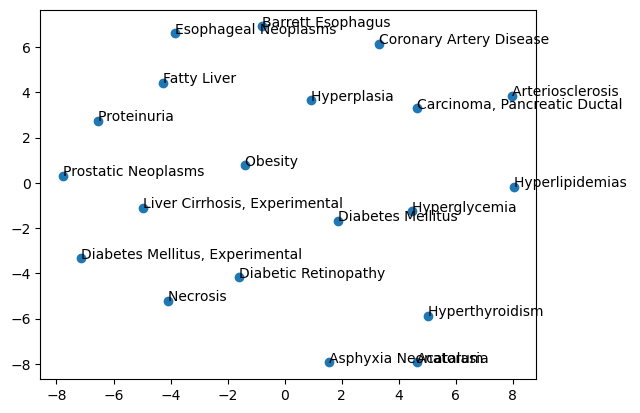

In [131]:
#nome_malattia    =  "MESH:D008223"   # LINFOMA
nome_malattia    = "MESH:D003920"    # DIABETE
#nome_malattia    = "MESH:D010300"    # PARKINSON 
#nome_malattia    = "MESH:D001146"    # ARITMIA  
#nome_malattia    = "MESH:D000744"    # ANEMIA
#nome_malattia    = "MESH:D008180"    # LUPUS
#nome_malattia     = "MESH:D012148"    # sindrome delle gambe senza riposo


malattia = V[np.array([diseases == nome_malattia]).argmax()]
distanze = np.linalg.norm( V - malattia, axis = 1 )
nomi_malattie = diseases
coppie   = np.c_[np.arange(len(diseases)),nomi_malattie,distanze]
coppie   = coppie[distanze.argsort()]
vicini   = np.array(coppie[:20])
V_vicini = np.array(V)[vicini[:,0].astype(int)]


from sklearn.manifold import MDS
embedding = MDS(n_components = 2).fit_transform(V_vicini)
plt.scatter(embedding[:,0],embedding[:,1])
for coppia,e in zip(coppie,embedding):
    mesh_id_symbol = coppia[1].split(':')[1]
    try:
        nome = get_mesh_title(mesh_id_symbol)
    except:
        print("something wrong")
        nome = coppia[1]
    print(nome)
    plt.annotate( nome ,e)


#V_vicini = V[np.array(vicini[:,0])]
#V_vicini



# Embedding analysis of chemicals

In [144]:
import urllib.request
def get_mesh_title(mesh_id):
    url = "https://alpha.dmi.unict.it/dtweb/search.php?query=%s" % mesh_id
    fp = urllib.request.urlopen(url)
    mybytes = fp.read()

    mystr = mybytes.decode("utf8")
    fp.close()
    tokens = mystr.split("\n")
    return (tokens[130].split("<b>")[1].split("</b>")[0])

get_mesh_title("DB00643")

'Mebendazole'

In [188]:
(1 + 1e-3)**5000

148.0428361625591

In [192]:
B_train = build_training_set(B_test,0.99)
V,W = train(B_train,B_test, 30, 1e-3, 1e-2, maxiter = 5000, mute = True, set_seed = True)
confusion_matrix(V,W,B_test)

array([[0.91752577, 0.08247422],
       [0.05319113, 0.9468089 ]], dtype=float32)

Alprazolam
Clonazepam
Adinazolam
Chlordiazepoxide
Lorazepam
Zopiclone
Temazepam
Pheniramine
Eszopiclone
Loxapine
Nitrazepam
Fluphenazine
Tranylcypromine
Desipramine
Vanoxerine
Rasagiline
Triazolam
Flurazepam
Remifentanil
Levetiracetam
Methotrimeprazine
Piperazine
Lamotrigine
Cytidine
Etorphine
Trimipramine
Estazolam
Loperamide
Diethylpropion
Porphobilinogen
Thiothixene
Polythiazide
Vardenafil
Diprenorphine
Oxcarbazepine
Isocarboxazid
Mephentermine
Trifluoperazine
Nandrolone phenpropionate
4-Bromo-2,5-dimethoxyamphetamine
Methoxyflurane
Lisdexamfetamine
Carbinoxamine
Aminophylline
Delorazepam
Doxapram
Maprotiline
Bromazepam
Risperidone
Phenelzine
Salmon Calcitonin
Moricizine
Hexobarbital
Methylphenobarbital
Ziprasidone
Metoclopramide
Cathinone
Nalbuphine
Flumazenil
Oxymetazoline
Pivmecillinam
Biperiden
Carisoprodol
Chlorprothixene
Lisuride
Paliperidone
Cyclobenzaprine
Pemoline
Trichlormethiazide
Cyclopentolate
Atomoxetine
Pirenzepine
Olsalazine
Amlexanox
Isoetharine
Dexmedetomidine
Pent

Azatadine
Tinidazole
Penicillin V
3-Indolebutyric Acid
Spectinomycin
Daptomycin
Flunisolide
5-Nitroindazole
Icosapent
Hydroxyzine
Allylestrenol
Methylphenidate
Tridihexethyl
Posaconazole
ECGONINE METHYL ESTER
Flecainide
Guaifenesin
Roflumilast
Epinastine
2'-Deoxyguanosine-5'-Triphosphate
Procainamide
Benzimidazole
Enfuvirtide
Betaxolol
Idarubicin
Oxyphenonium
Dimethylallyl Diphosphate
Secobarbital
Chlorpropamide
Digitoxin
Levocabastine
Bevantolol
Megestrol
Dirithromycin
Fentanyl
Phentermine
Tegaserod
Dimethylformamide
Cathine
Arbutamine
Aprepitant
Diatrizoate
Magnesium Sulfate
Benzoylformic Acid
Benzyl Benzoate
Estramustine
Hexachlorophene
Papaverine
Isradipine
Tolazamide
Azlocillin
Josamycin
Paramethasone
Butyrylthiocholine
Flunarizine
Alizapride
Ceftazidime
Bambuterol
2'-Deoxycytidine
Travoprost
Trihexyphenidyl
Hymenialdisine
Terconazole
Dorzolamide
Miglustat
Quinolinic Acid
Azelastine
Colestipol
4-Hydroxy-3-Methoxybenzoate
Antrafenine
Brinzolamide
2-Oxo-4-Methylpentanoic Acid
Clomif

L-Carnitine
Dazoxiben
Cefaclor
Oxybenzone
Cisapride
Felodipine
Dutasteride
Phosphatidylethanolamine
Pantoprazole
Dicumarol
Guanosine-5'-Triphosphate
Azithromycin
3,4-Dihydroxycinnamic Acid
Budesonide
Grepafloxacin
Diflunisal
Anagrelide
Allopurinol
Butan-1-Ol
Danazol
Clopidogrel
Meclofenamic acid
Acetazolamide
Ciprofloxacin
N-(3-(Aminomethyl)Benzyl)Acetamidine
Metyrapone
Streptomycin
Guanidine
Propidium
Mycophenolate mofetil
Clioquinol
Clofazimine
HESPERIDIN
Methysergide
Tazobactam
Rivastigmine
Calyculin A
Alprenolol
Fumarate
Calcipotriol
2-Aminophenol
2-(3,4-Dihydroxyphenyl)Acetic Acid
2-Hydroxyethyl Disulfide
Oxytocin
Indirubin-3'-Monoxime
Thiabendazole
Diphosphate
Prazosin
Hesperetin
Tacrine
5-methyltetrahydrofolate
Mebendazole
Sucrose Octasulfate
5'-Deoxy-5'-Methylthioadenosine
Mefenamic acid
Letrozole
Bicalutamide
Flurandrenolide
Cinacalcet
Ethosuximide
Cilostazol
Fluocinolone Acetonide
Triamcinolone
Acenocoumarol
Lansoprazole
Magnesium
ACETOPHENONE
Estriol
Argatroban
Norfloxacin
A

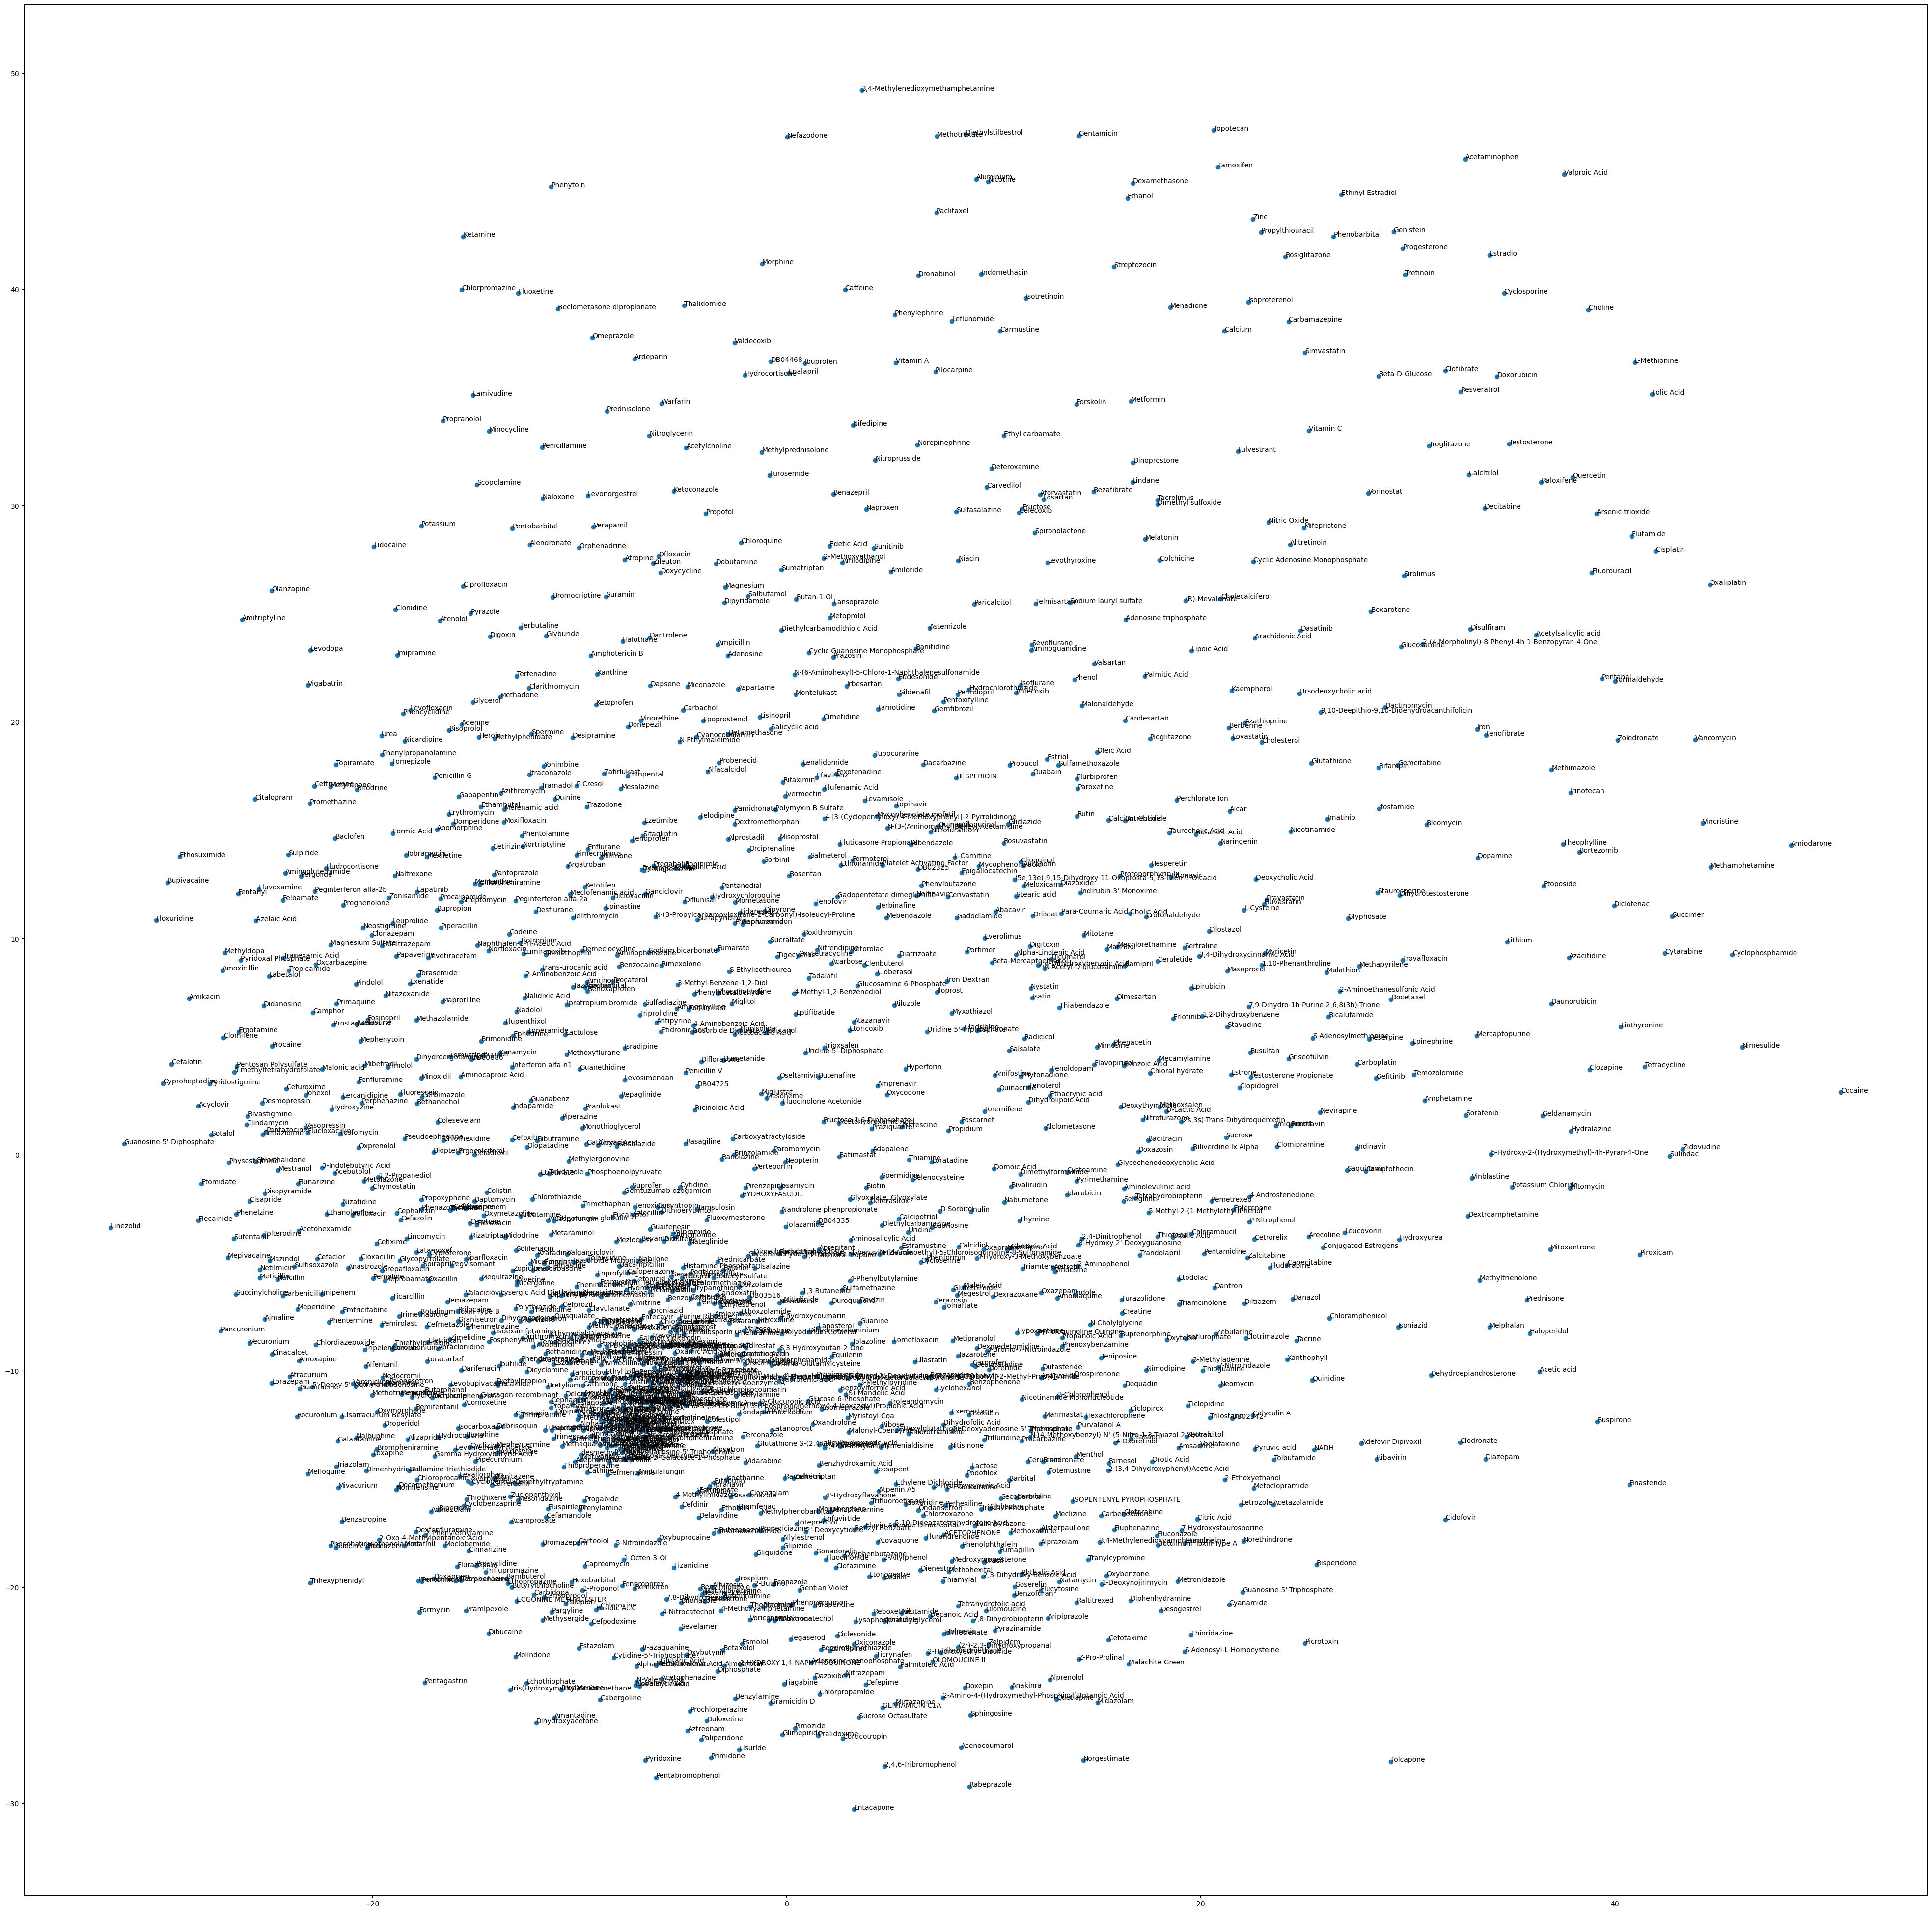

In [198]:
nome_chemical    = "DB00404"    #aspirina


chemical = W[np.array([chemicals == nome_chemical]).argmax()]
distanze = np.linalg.norm( W -  chemical, axis = 1 )
nomi_chemicals = chemicals
coppie   = np.c_[np.arange(len(chemicals)),nomi_chemicals,distanze]
coppie   = coppie[distanze.argsort()]
vicini   = np.array(coppie[:len(coppie)])
W_vicini = np.array(W)[vicini[:,0].astype(int)]

from sklearn.manifold import MDS
embedding = MDS(n_components = 2).fit_transform(W_vicini)
plt.figure(figsize= (50,50))
plt.scatter(embedding[:,0],embedding[:,1])
#plt.scatter(embedding[0,0],embedding[0,1], s = 100. , color = 'red')

for coppia,e in zip(coppie,embedding):
    mesh_id_symbol = coppia[1]
    try:
        nome = get_mesh_title(mesh_id_symbol)
    except:
        print("something wrong")
        nome = coppia[1]
    print(nome)
    plt.annotate( nome ,e)


#V_vicini = V[np.array(vicini[:,0])]
#V_vicini



(10, 10)